# Machine Learning Problem Set 1

**Sean Andrew Chen, MPA 2**

**sachen@princeton.edu**

# Setup Notebook

In [703]:
from __future__ import print_function, division

import urllib
import os, shutil
import zipfile

import numpy as np
import pandas as pd

import statsmodels.api as sm
#there's some sorta weird bug here and this is a brute force workaround
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

import matplotlib.pyplot as plt;

# Download and Clean Data

## Download and Move Data

In [3]:
url = "https://www1.nyc.gov/assets/nypd/downloads/zip/analysis_and_planning/stop-question-frisk/sqf-2016-csv.zip"
fileName = "sqf-2016-csv.zip"
urllib.request.urlretrieve(url, fileName);

path = os.getcwd()
oldFile = path + "/" + fileName
newFile = path + "/data/" + "fileName"
shutil.move(oldFile, newFile);

zip_ref = zipfile.ZipFile(newFile, 'r')
zip_ref.extractall(path + "/data")
zip_ref.close()

## Read Data with Pandas

In [677]:
stopFriskData = pd.read_csv('data/sqf-2016.csv', low_memory = False)

## Clean Data

### Drop Unneeded Columns

In [678]:
keepColumns = ['frisked', 'race', 'age', 'weight', 'ht_feet', 'ht_inch', 'sex', 'build']

In [679]:
allData = pd.DataFrame(stopFriskData, columns=keepColumns)

In [680]:
columnNames = ['frisked', 'race', 'age', 'weight', 'heightFeet',
             'heightInches', 'sex', 'build']
allData.columns = columnNames

### Drop NAs and Incorrect Inputs

In [681]:
#There were some mistakes in data entry
allData = allData.dropna(axis=0, how='all')
allData = allData[:-1]
allData = allData[allData['age'] != '**']
allData = allData[allData['sex'] != 'Z']

### Relabel Categorical Variables

In [682]:
raceLabels = ['A', 'B', 'I', 'P', 'Q', 'W', 'U', 'Z']
raceFactors = ['ASIAN', 'BLACK', 'AMERICAN INDIAN', 'HISPANIC', 'HISPANIC', 'WHITE', 'OTHER', 'OTHER']
allData['race'].replace(raceLabels, raceFactors, inplace=True)

In [683]:
#We'll say that we have a scale of scrawny to bulky with an added value of one each rung up the scale
buildLabels = ['H', 'M', 'T', 'U', 'Z']
buildFactors = [3, 2, 1, 4, 0]
allData['build'].replace(buildLabels, buildFactors, inplace=True)

In [684]:
allData = allData.replace('M', 1)
allData = allData.replace('F', 0)

### Create One Height Variable

In [685]:
allData['height'] = (allData.heightFeet.astype(float) * 12) + allData.heightInches.astype(float)
allData = allData.drop(['heightFeet', 'heightInches'], axis = 1)

### Check Data

In [686]:
allData.head()

,frisked,race,age,weight,sex,build,height
0,Y,BLACK,48,180,1,1,74.0
1,N,WHITE,20,150,1,1,68.0
2,Y,HISPANIC,34,140,1,2,66.0
3,Y,BLACK,33,180,1,2,69.0
4,N,BLACK,22,160,1,1,71.0


### Create Dataframe For Those Frisked

In [687]:
friskedData = allData[allData.frisked == 'Y']

## Summarize Data

In [689]:
numberObservations = friskedData.count()[0]
print(numberObservations)

7885


In [690]:
race = friskedData.groupby(['race']).size()

In [691]:
race / numberObservations * 100

race
AMERICAN INDIAN     0.266328
ASIAN               5.504122
BLACK              54.787571
HISPANIC           29.727330
OTHER               1.407736
WHITE               8.306912
dtype: float64

In [693]:
raceData = list(friskedData.race.value_counts() / numberObservations * 100)
races = ['BLACK', 'HISPANIC', 'WHITE', 'ASIAN', 'OTHER', 'AMERICAN INDIAN']
raceFrequency = dict(zip(raceData, races))

# Visualize Data

## Normalized Histogram

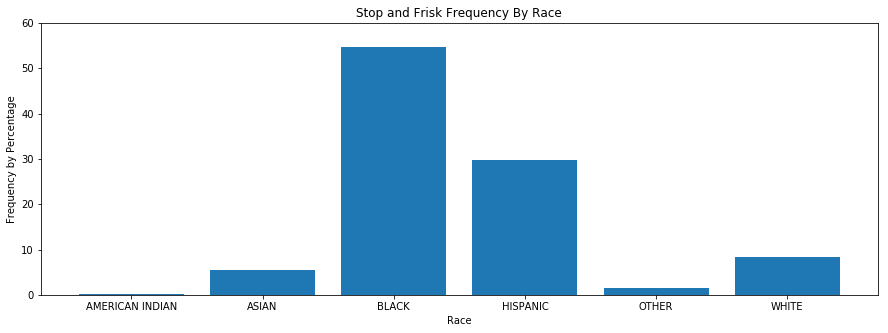

In [695]:
plt.figure(figsize=(15, 5))
plt.bar(raceFrequency.values(), raceFrequency.keys());
plt.ylim(0, 60);
plt.title('Stop and Frisk Frequency By Race');
plt.xlabel('Race');
plt.ylabel('Frequency by Percentage');

## Histogram

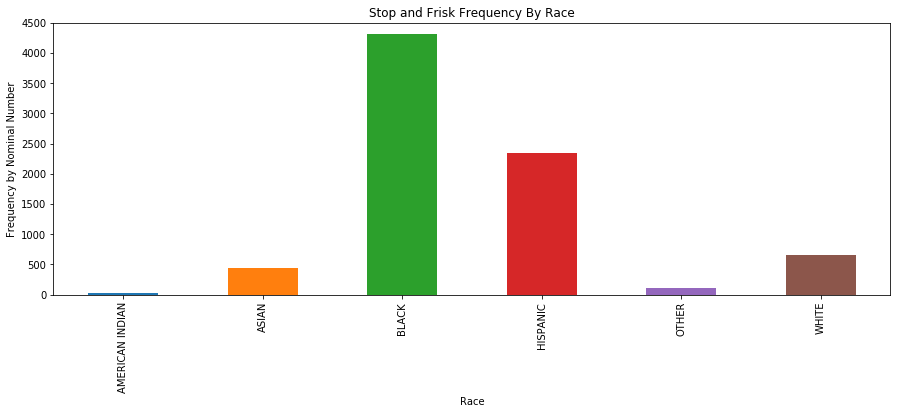

In [696]:
plt.figure(figsize = (15, 5))
friskedData.groupby('race').size().plot(kind='bar');
plt.title('Stop and Frisk Frequency By Race');
plt.xlabel('Race');
plt.ylabel('Frequency by Nominal Number');
plt.ylim(0, 4500);

## Pie Plot

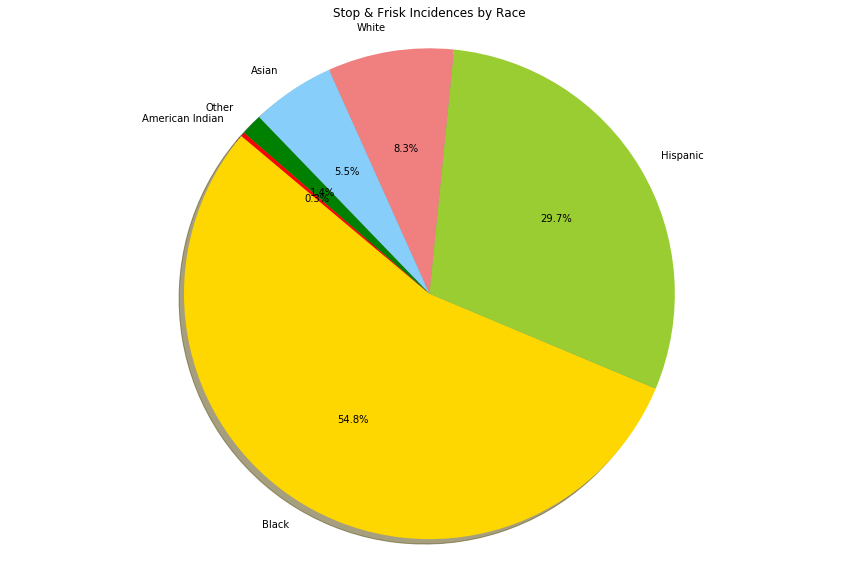

In [697]:
# Data to plot
labels = 'Black', 'Hispanic', 'White', 'Asian', 'Other', 'American Indian'
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'green', 'red', 'purple', 'gray']
 
# Plot
plt.figure(figsize=(15, 10))
plt.pie(raceData, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.title('Stop & Frisk Incidences by Race')
plt.show()

# Fix Dummy Variables

Pandas allows replacement without having to go through a loop. 

In [698]:
allData = allData.replace('Y', 1)
allData = allData.replace('N', 0)
allData.head()

,frisked,race,age,weight,sex,build,height
0,1,BLACK,48,180,1,1,74.0
1,0,WHITE,20,150,1,1,68.0
2,1,HISPANIC,34,140,1,2,66.0
3,1,BLACK,33,180,1,2,69.0
4,0,BLACK,22,160,1,1,71.0


# Logit Regression

In [704]:
X = allData.copy()
y = X.frisked.copy()
X.drop(['frisked', 'race'], axis=1, inplace=True)
X['intercept'] = 1.0  

In [705]:
logitModel = sm.Logit(y.astype(float), X.astype(float))
result = logitModel.fit()

Optimization terminated successfully.
         Current function value: 0.639464
         Iterations 5


In [706]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                frisked   No. Observations:                12312
Model:                          Logit   Df Residuals:                    12306
Method:                           MLE   Df Model:                            5
Date:                Tue, 27 Feb 2018   Pseudo R-squ.:                 0.02098
Time:                        17:30:14   Log-Likelihood:                -7873.1
converged:                       True   LL-Null:                       -8041.8
                                        LLR p-value:                 8.712e-71
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0152      0.002     -9.227      0.000      -0.018      -0.012
weight         0.0009      0.001      1.492      0.136      -0.000       0.002
sex            0.9159      0.075     12.193      0.0

What this is saying is that by being male, you automatically increase your likelihood of being stopped and frisked by 1.91 times. For every inch you gain, your likelihood increases by 1.03 times. For each increasing body type build, you are 1.06 times more likely to be stopped. However, for every year you age, you are 1.01 times less likely to be stopped. 